# TODO

## Rly high level
- Explain what is the simulator 
- What state inside
- Details on each subpart of the state (sim, agents, entities)
- How to instantiate a state ...
- How to instantiate a simulator
- How to run it ... 

## More low level ..
- Focus more on details
- Physics engine
- How to create a simulation ... 

# Little example 
- Entities w different behaviors ... 

here we have a simulation w a state that evolves 

state composed of 4  elements :
- simulator_state: (general informations on the simulator ...)
- agent_state: some information about agents (mostly linked to braitenberg vehicles atm)
- object_state: some information about objects (only color atm)
- entity_state: information about agents and objects (pos, speeds, mass, ...) basically all physical parameters used in a physics simulation 

Atm we regroup all these physical parameters to make it easier to compute things in the physics simulation 

--> Should also remove all the information about proximeters from physics engine (i.e physics engine only an util function to provide help for collisions ...). Think the best thing for an user would be to have a kind of file to define an environment (e.g EvoJax, JaxMARL) and import physics fn from physics engine (prox ... would be computed here). Can be wrapped with simulator (doesn't wrap a state but an env that can step ...) Then in the simulator use run fns ... that call this step.

--> Also something more general like obs for agents, in braitenberg case they are sensors (could be vision ... right ?)

All parameters used in a simulation

<div style="font-size: 80%;">

```yaml
agents:
  behavior: 1
  color: blue
  max_speed: 10.0
  prox_cos_min: 0.0
  prox_dist_max: 40.0
  speed_mul: 1.0
  theta_mul: 1.0
  wheel_diameter: 2.0

entities:
  agents_positions: null
  diameter: 5.0
  existing_agents: null
  existing_objects: null
  friction: 0.1
  mass_center: 1.0
  mass_orientation: 0.125
  objects_positions: null
  seed: 0

objects:
  color: red

simulator:
  box_size: 100.0
  collision_alpha: 0.5
  collision_eps: 0.1
  dt: 0.1
  freq: 40.0
  max_agents: 10
  max_objects: 2
  neighbor_radius: 100.0
  num_steps_lax: 4
  to_jit: true
  use_fori_loop: false


```

</div>

In [1]:
import jax.numpy as jnp
from jax import random

### Create simulator state

contains general info abt the simulator, n objects and agents ... but also parameters abt simulation running (use jit or not, use fori_loop, num steps per update loop ...) parameters abt sim speed and update freq for interface (dt, freq), parameters abt physics of the environment (collision_alpha, collision_eps)

In [2]:
from vivarium.simulator.states import SimulatorState

box_size = 100.
max_agents = 10
max_objects = 2
num_steps_lax = 4
dt = -1.
freq = 40.
neighbor_radius = 100.
to_jit = True
use_fori_loop = False
collision_alpha = 0.5
collision_eps = 0.1

simulator_state = SimulatorState(
    idx=jnp.array([0]),
    box_size=jnp.array([box_size]),              
    max_agents=jnp.array([max_agents]),
    max_objects=jnp.array([max_objects]),
    num_steps_lax=jnp.array([num_steps_lax], dtype=int),
    dt=jnp.array([dt], dtype=float),
    freq=jnp.array([freq], dtype=float),
    neighbor_radius=jnp.array([neighbor_radius], dtype=float),
    # Use 1*bool to transform True to 1 and False to 0
    to_jit= jnp.array([1*to_jit]),
    use_fori_loop=jnp.array([1*use_fori_loop]),
    collision_alpha=jnp.array([collision_alpha]),
    collision_eps=jnp.array([collision_eps]))

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


### Create agents state

All information about the agents that are not shared by other entities  (not exactly with color)
 
Should maybe put entities state first ? 

In [3]:
from vivarium.simulator.states import AgentState

max_agents = 10
behavior = 1
wheel_diameter = 2.
speed_mul = 1.
max_speed = 10.
theta_mul = 1.
prox_dist_max = 40.
prox_cos_min = 0.
agents_color = jnp.array([0., 0., 1.])

agents_state = AgentState(
    nve_idx=jnp.arange(max_agents, dtype=int),
    prox=jnp.zeros((max_agents, 2)),
    motor=jnp.zeros((max_agents, 2)),
    behavior=jnp.full((max_agents), behavior),
    wheel_diameter=jnp.full((max_agents), wheel_diameter),
    speed_mul=jnp.full((max_agents), speed_mul),
    max_speed=jnp.full((max_agents), max_speed),
    theta_mul=jnp.full((max_agents), theta_mul),
    proxs_dist_max=jnp.full((max_agents), prox_dist_max),
    proxs_cos_min=jnp.full((max_agents), prox_cos_min),
    color=jnp.tile(agents_color, (max_agents, 1))
    )

### Create objects state

same for objects

In [4]:
from vivarium.simulator.states import ObjectState

max_objects = 2
objects_color = jnp.array([1., 0., 0.])

start_idx, stop_idx = max_agents, max_agents + max_objects
objects_nve_idx = jnp.arange(start_idx, stop_idx, dtype=int)

objects_state = ObjectState(
    nve_idx=objects_nve_idx,
    color=jnp.tile(objects_color, (max_objects, 1))
)

### Create entities state

contains all physical parameters (position, mass, momentum, friction ... about )

In [5]:
from vivarium.simulator.states import EntityState, EntityType
from jax_md.rigid_body import RigidBody

n_dims = 2 # 2D world
diameter = 5.
friction = 0.1
mass_center = 1.
mass_orientation = 0.125
existing_agents = 5
existing_objects = 1
seed = 0

n_entities = max_agents + max_objects

key = random.PRNGKey(seed)
key, key_agents_pos, key_objects_pos, key_orientations = random.split(key, 4)

# Assign random positions to each entities
agents_positions = positions = random.uniform(key_agents_pos, (max_agents, n_dims)) * box_size
objects_positions = positions = random.uniform(key_objects_pos, (max_objects, n_dims)) * box_size
positions = jnp.concatenate((agents_positions, objects_positions))

# Assign random orientations between 0 and 2*pi
orientations = random.uniform(key_orientations, (n_entities,)) * 2 * jnp.pi

# Assign types to the entities
agents_entities = jnp.full(max_agents, EntityType.AGENT.value)
object_entities = jnp.full(max_objects, EntityType.OBJECT.value)
entity_types = jnp.concatenate((agents_entities, object_entities), dtype=int)

# Define arrays with existing entities
exists_agents = jnp.concatenate((jnp.ones((existing_agents)), jnp.zeros((max_agents - existing_agents))))
exists_objects = jnp.concatenate((jnp.ones((existing_objects)), jnp.zeros((max_objects - existing_objects))))
exists = jnp.concatenate((exists_agents, exists_objects), dtype=int)

entity_state = EntityState(
    position=RigidBody(center=positions, orientation=orientations),
    momentum=None,
    force=RigidBody(center=jnp.zeros((n_entities, 2)), orientation=jnp.zeros(n_entities)),
    mass=RigidBody(center=jnp.full((n_entities, 1), mass_center), orientation=jnp.full((n_entities), mass_orientation)),
    entity_type=entity_types,
    entity_idx = jnp.array(list(range(max_agents)) + list(range(max_objects))),
    diameter=jnp.full((n_entities), diameter),
    friction=jnp.full((n_entities), friction),
    exists=exists
    )


In [6]:

from vivarium.simulator.states import State

state = State(
        simulator_state=simulator_state,
        agent_state=agents_state,
        object_state=objects_state,
        entity_state=entity_state
    )

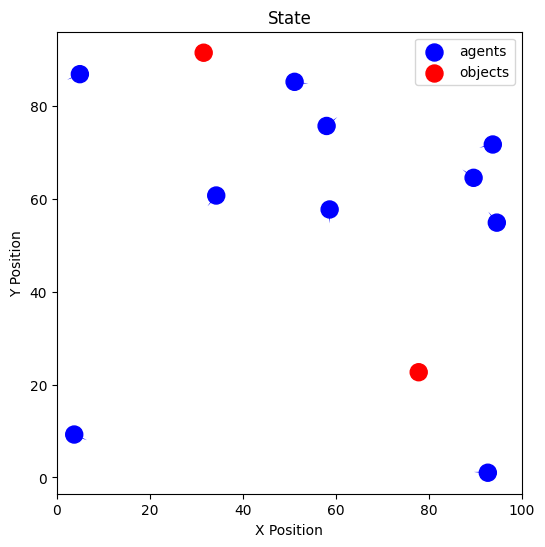

In [7]:
from jax import vmap
import matplotlib.pyplot as plt 

@vmap 
def normal(theta):
    return jnp.array([jnp.cos(theta), jnp.sin(theta)])

def render(entity_state):
    plt.figure(figsize=(6, 6))
    plt.xlim(0, box_size)
    plt.xlim(0, box_size)

    # Could replace this system to have agents and objects idx 
    agents_pos = entity_state.position.center[:max_agents]
    agents_theta = entity_state.position.orientation[:max_agents]
    agents_diameter = entity_state.diameter[:max_agents]
    objects_pos = entity_state.position.center[max_agents:]
    object_diameter = entity_state.diameter[max_agents:]

    x_agents, y_agents = agents_pos[:, 0], agents_pos[:, 1]
    x_objects, y_objects = objects_pos[:, 0], objects_pos[:, 1]
    n = normal(agents_theta)

    arrow_length = 3  # Length of the arrow
    size_scale = 30  # I do this bc I don't rly understand how s works with matplotlib scatter
    dx = arrow_length * n[:, 0]
    dy = arrow_length *  n[:, 1]
    plt.quiver(x_agents, y_agents, dx, dy, color='blue', scale=1, scale_units='xy', headwidth=0.8, angles='xy', width=0.01)
    plt.scatter(x_agents, y_agents, color='blue', s=agents_diameter*size_scale, label='agents')
    plt.scatter(x_objects, y_objects, color='red', s=object_diameter*size_scale, label='objects')

    plt.title('State')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.legend()

    plt.show()

render(state.entity_state)

### Wrap the state inside a simulator

In [8]:
from vivarium.simulator import behaviors
from vivarium.simulator.simulator import Simulator
from vivarium.simulator.physics_engine import dynamics_rigid

simulator = Simulator(state, behaviors.behavior_bank, dynamics_rigid)

You can also init a state with a yaml config file like this : 

<div style="font-size: 85%;">

```python
from vivarium.simulator.states import init_state

@hydra.main(version_base=None, config_path="../conf", config_name="config")
def main(cfg: DictConfig = None) -> None:

    args = OmegaConf.merge(cfg.default, cfg.scene)
    state = init_state(args)
    simulator = Simulator(state, behaviors.behavior_bank, dynamics_rigid)
```
</div>

In [10]:
num_steps = 100
simulator.run(num_steps=num_steps, save=True)
state = simulator.state
# render(state)

In [ ]:
print(state.simulator_state)

SimulatorState(idx=Array([0], dtype=int32), box_size=Array([100.], dtype=float32), max_agents=Array([10], dtype=int32), max_objects=Array([2], dtype=int32), num_steps_lax=Array([4], dtype=int32), dt=Array([-1.], dtype=float32), freq=Array([40.], dtype=float32), neighbor_radius=Array([100.], dtype=float32), to_jit=Array([1], dtype=int32), use_fori_loop=Array([0], dtype=int32), collision_alpha=Array([0.5], dtype=float32), collision_eps=Array([0.1], dtype=float32))


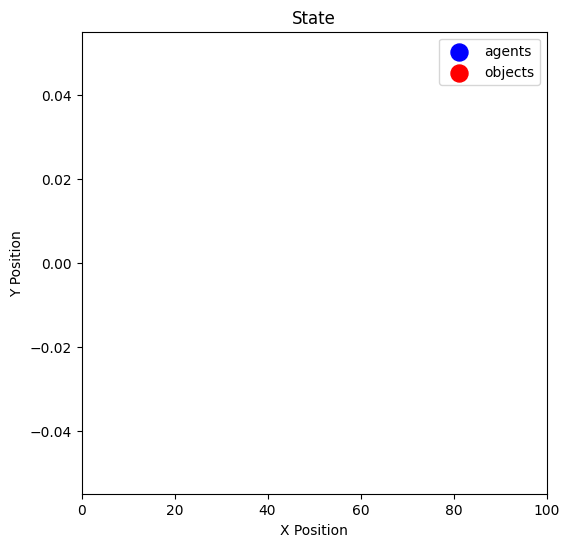

In [ ]:
num_steps = 1000
simulator.run(num_steps=num_steps)
state = simulator.state
render(state)